<a href="https://colab.research.google.com/github/abdullahemam252/abdullahemam252/blob/main/sign_language_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from PIL import Image
from tqdm import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Import Data

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

! kaggle datasets download -d datamunge/sign-language-mnist

cp: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/datamunge/sign-language-mnist
License(s): CC0-1.0
100% 62.6M/62.6M [00:00<00:00, 163MB/s] 
100% 62.6M/62.6M [00:00<00:00, 131MB/s]


In [4]:
! unzip /content/sign-language-mnist.zip

Archive:  /content/sign-language-mnist.zip
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


In [5]:
train = pd.read_csv('/content/sign_mnist_train/sign_mnist_train.csv')
test = pd.read_csv('/content/sign_mnist_test/sign_mnist_test.csv')

In [6]:
train.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [7]:
X = train.drop(['label'], axis = 1)
y = train['label']

In [8]:
X.shape, y.shape

((27455, 784), (27455,))

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Hyperparameters

In [10]:
BATCH_SIZE = 32
IMAGE_SIZE = 28
NUM_CLASS = y.nunique() + 1

# Preprocessing and Data Loader

In [11]:
random_transforms = transforms.Compose([
    transforms.RandomRotation(30),  # Randomly rotate the image by up to 30 degrees
    # transforms.RandomResizedCrop(IMAGE_SIZE),  # Randomly crop and resize the image to 224x224
    # transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
])

# Define the fixed transformations
fixed_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Define the overall transformation pipeline
transform = transforms.Compose([
    transforms.RandomApply([random_transforms], p=0.5),  # Apply random transformations with a probability of 0.5
    fixed_transforms
])

In [12]:
class SignDataSet(Dataset):
  def __init__(
      self,
      image_df,
      label_df,
      transform,
      split = None,
  ):
    self.image_df = image_df
    self.label_df = torch.nn.functional.one_hot(torch.tensor(np.array(label_df))).float()
    self.split = split
    self.transform = transform

  def __len__(self):
    return len(self.label_df)

  def __getitem__(self, index):
    image = self.image_df.iloc[index]
    image = np.reshape(np.array(image), (28,28))

    image = Image.fromarray(image.astype(np.uint8))

    label = self.label_df[index]
    # label = torch.nn.functional.one_hot(torch.tensor(label))

    if self.split == 'train':
      image = self.transform(image)
    return image, label





In [13]:

train_data = SignDataSet(X_train, y_train, transform, 'train')
test_data = SignDataSet(X_val, y_val, transform)

In [14]:
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, drop_last = True)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, drop_last = True)

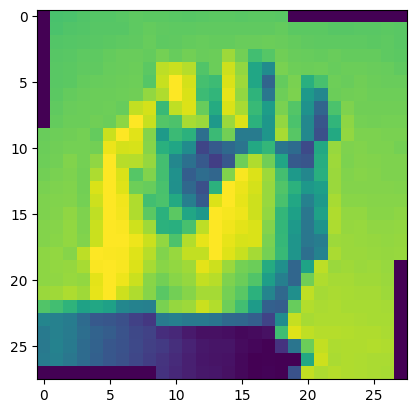

In [23]:
for i, j in train_data:
  temp_img = i

  plt.imshow(temp_img.permute(1,2,0))
  break

# Model Building

In [24]:
class SignLabelModel(nn.Module):
    def __init__(self, num_classes):
        super(SignLabelModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Create an instance of the model
  # Number of classes
model = SignLabelModel(NUM_CLASS).to(device)

In [25]:
num_epochs = 20
criterion  = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [26]:
for epoch in tqdm(range(num_epochs)):
    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to the device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images.to(device))
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print training progress
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("Training finished.")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], Loss: 3.1043
Epoch [1/20], Loss: 2.7907
Epoch [1/20], Loss: 2.4792
Epoch [1/20], Loss: 1.9886
Epoch [1/20], Loss: 1.7989
Epoch [1/20], Loss: 1.4832


  5%|▌         | 1/20 [00:12<04:04, 12.89s/it]

Epoch [2/20], Loss: 1.6389
Epoch [2/20], Loss: 1.0900
Epoch [2/20], Loss: 1.4652
Epoch [2/20], Loss: 0.9198
Epoch [2/20], Loss: 1.1032
Epoch [2/20], Loss: 0.8785


 10%|█         | 2/20 [00:23<03:30, 11.70s/it]

Epoch [3/20], Loss: 0.9058
Epoch [3/20], Loss: 0.6182
Epoch [3/20], Loss: 1.5498
Epoch [3/20], Loss: 0.7639
Epoch [3/20], Loss: 0.7246
Epoch [3/20], Loss: 0.6658


 15%|█▌        | 3/20 [00:35<03:15, 11.52s/it]

Epoch [4/20], Loss: 0.6354
Epoch [4/20], Loss: 0.4997
Epoch [4/20], Loss: 0.7839
Epoch [4/20], Loss: 0.6345
Epoch [4/20], Loss: 0.7019
Epoch [4/20], Loss: 0.4624


 20%|██        | 4/20 [00:46<03:05, 11.57s/it]

Epoch [5/20], Loss: 0.9988
Epoch [5/20], Loss: 0.5193
Epoch [5/20], Loss: 0.9070
Epoch [5/20], Loss: 0.5314
Epoch [5/20], Loss: 0.5303
Epoch [5/20], Loss: 0.4190


 25%|██▌       | 5/20 [00:58<02:53, 11.55s/it]

Epoch [6/20], Loss: 0.4713
Epoch [6/20], Loss: 0.2736
Epoch [6/20], Loss: 0.6238
Epoch [6/20], Loss: 0.3601
Epoch [6/20], Loss: 0.3265
Epoch [6/20], Loss: 0.3581


 30%|███       | 6/20 [01:09<02:41, 11.55s/it]

Epoch [7/20], Loss: 0.3911
Epoch [7/20], Loss: 0.4525
Epoch [7/20], Loss: 0.5181
Epoch [7/20], Loss: 0.3788
Epoch [7/20], Loss: 0.3836
Epoch [7/20], Loss: 0.4142


 35%|███▌      | 7/20 [01:23<02:40, 12.36s/it]

Epoch [8/20], Loss: 0.4746
Epoch [8/20], Loss: 0.2038
Epoch [8/20], Loss: 0.4693
Epoch [8/20], Loss: 0.1878
Epoch [8/20], Loss: 0.1989
Epoch [8/20], Loss: 0.1551


 40%|████      | 8/20 [01:38<02:38, 13.22s/it]

Epoch [9/20], Loss: 0.2557
Epoch [9/20], Loss: 0.2101
Epoch [9/20], Loss: 0.2467
Epoch [9/20], Loss: 0.0968
Epoch [9/20], Loss: 0.1836
Epoch [9/20], Loss: 0.2299


 45%|████▌     | 9/20 [01:51<02:21, 12.89s/it]

Epoch [10/20], Loss: 0.3879
Epoch [10/20], Loss: 0.3284
Epoch [10/20], Loss: 0.3461
Epoch [10/20], Loss: 0.3278
Epoch [10/20], Loss: 0.1864
Epoch [10/20], Loss: 0.0900


 50%|█████     | 10/20 [02:02<02:04, 12.47s/it]

Epoch [11/20], Loss: 0.0918
Epoch [11/20], Loss: 0.2089
Epoch [11/20], Loss: 0.1185
Epoch [11/20], Loss: 0.0748
Epoch [11/20], Loss: 0.1024
Epoch [11/20], Loss: 0.0962


 55%|█████▌    | 11/20 [02:15<01:54, 12.70s/it]

Epoch [12/20], Loss: 0.2189
Epoch [12/20], Loss: 0.1299
Epoch [12/20], Loss: 0.3789
Epoch [12/20], Loss: 0.1002
Epoch [12/20], Loss: 0.0886
Epoch [12/20], Loss: 0.1879


 60%|██████    | 12/20 [02:27<01:38, 12.35s/it]

Epoch [13/20], Loss: 0.2574
Epoch [13/20], Loss: 0.1249
Epoch [13/20], Loss: 0.0944
Epoch [13/20], Loss: 0.0501
Epoch [13/20], Loss: 0.1337
Epoch [13/20], Loss: 0.0499


 65%|██████▌   | 13/20 [02:38<01:23, 11.94s/it]

Epoch [14/20], Loss: 0.0731
Epoch [14/20], Loss: 0.0859
Epoch [14/20], Loss: 0.0563
Epoch [14/20], Loss: 0.0914
Epoch [14/20], Loss: 0.1071
Epoch [14/20], Loss: 0.1206


 70%|███████   | 14/20 [02:50<01:11, 11.90s/it]

Epoch [15/20], Loss: 0.3147
Epoch [15/20], Loss: 0.1150
Epoch [15/20], Loss: 0.0878
Epoch [15/20], Loss: 0.1756
Epoch [15/20], Loss: 0.1083
Epoch [15/20], Loss: 0.1496


 75%|███████▌  | 15/20 [03:02<01:00, 12.01s/it]

Epoch [16/20], Loss: 0.0440
Epoch [16/20], Loss: 0.0507
Epoch [16/20], Loss: 0.1481
Epoch [16/20], Loss: 0.1224
Epoch [16/20], Loss: 0.3149
Epoch [16/20], Loss: 0.1755


 80%|████████  | 16/20 [03:13<00:47, 11.87s/it]

Epoch [17/20], Loss: 0.0691
Epoch [17/20], Loss: 0.0858
Epoch [17/20], Loss: 0.0423
Epoch [17/20], Loss: 0.0881
Epoch [17/20], Loss: 0.0551
Epoch [17/20], Loss: 0.0685


 85%|████████▌ | 17/20 [03:25<00:35, 11.81s/it]

Epoch [18/20], Loss: 0.0744
Epoch [18/20], Loss: 0.0719
Epoch [18/20], Loss: 0.0508
Epoch [18/20], Loss: 0.0196
Epoch [18/20], Loss: 0.0459
Epoch [18/20], Loss: 0.1509


 90%|█████████ | 18/20 [03:37<00:23, 11.74s/it]

Epoch [19/20], Loss: 0.0974
Epoch [19/20], Loss: 0.0370
Epoch [19/20], Loss: 0.1299
Epoch [19/20], Loss: 0.0724
Epoch [19/20], Loss: 0.0324
Epoch [19/20], Loss: 0.1432


 95%|█████████▌| 19/20 [03:48<00:11, 11.68s/it]

Epoch [20/20], Loss: 0.0213
Epoch [20/20], Loss: 0.0561
Epoch [20/20], Loss: 0.2433
Epoch [20/20], Loss: 0.0186
Epoch [20/20], Loss: 0.0486
Epoch [20/20], Loss: 0.0236


100%|██████████| 20/20 [03:59<00:00, 11.99s/it]

Training finished.


In [34]:
# Assuming 'model' is your trained PyTorch model
# and you have X_val, y_val properly defined for your test/validation data

# Set the model to evaluation mode
model.eval()

# No need for batch_size here if you're evaluating the entire test set at once
with torch.no_grad():  # Disable gradient calculation during evaluation
  # Reshape the input data to include channel and spatial dimensions
  # Assuming your images are grayscale (1 channel) and 28x28 pixels
  input_data = torch.tensor(X_val.values, dtype=torch.float32).view(-1, 1, 28, 28).to(device)

  # Make predictions
  outputs = model(input_data)  # Changed X_test to X_val
  _, predicted = torch.max(outputs, 1)

  # Calculate accuracy
  correct = (predicted == torch.tensor(y_val.values, dtype=torch.int64).to(device)).sum().item() # Changed y_test to y_val
  total = y_val.size  # Changed y_test to y_val
  accuracy = correct / total

print("Accuracy: ", accuracy)

Accuracy:  0.47186304862502276
